In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
# from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:
data = pd.read_csv('Code\\NEW\\scores_features.csv')
data_cleaned = data.drop(columns=['Unnamed: 0', 'Video Name'])

In [3]:
X = data_cleaned.drop(columns=['Quality Score']).values
y = data_cleaned['Quality Score'].values

In [4]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [6]:
# Define the MLP model (16, 16, 8 works okay)
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 8)
        self.fc2 = nn.Linear(8, 4)
        # self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(4, 1)
        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(x)
        x = self.tanh(self.fc2(x))
        # x = self.dropout(X)
        # x = self.relu(self.fc3(x))
        x = self.sigmoid(self.output(x))
        return x

In [7]:
# Training and evaluation metrics
# def calculate_metrics(outputs, targets):
#     """
#     Calculate MAE and Pearson correlation between predicted and actual targets.
#     """
#     # Detach tensors and convert to numpy for metric calculations
#     outputs = outputs.numpy()
#     targets = targets.numpy()

#     # Calculate MAE
#     mae = mean_absolute_error(targets, outputs)

#     # Calculate Pearson correlation
#     if len(targets) > 1:
#         pearson_corr, _ = pearsonr(targets, outputs)
#     else:
#         pearson_corr = float('nan')  # Pearson's correlation is undefined for single-element arrays

#     # Calculate RMSE
#     rmse = np.sqrt(np.mean((targets - outputs) ** 2))

#     return mae, pearson_corr, rmse

In [8]:
def calculate_metrics(true_labels, predictions):
    """
    Calculate MAE, RMSE, and R² given true labels and predictions.

    Args:
    - true_labels (numpy array): Ground truth values.
    - predictions (numpy array): Model predictions.

    Returns:
    - mae (float): Mean Absolute Error.
    - rmse (float): Root Mean Square Error.
    - r2 (float): R-squared value (Coefficient of Determination).
    """
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    rmse = np.sqrt(mean_squared_error(true_labels, predictions))
    
    
    return mae, r2, rmse

In [9]:
# Instantiate the model
input_dim = X_train.shape[1]
model = MLP(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-3)

# # Metrics to track
# train_losses = []
# mae_scores = []
# r2_scores = []
# rmse_scores = []

# dictionary to store error metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'train_mae': [],
    'val_mae': [],
    'train_rmse': [],
    'val_rmse': [],
    'train_pearson': [],
    'val_pearson': []
}

# Train the model
num_epochs = 500
batch_size = 4

# variables for early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

# Function to generate batches
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    all_train_outputs = []
    all_train_labels = []

    for X_batch, y_batch in get_batches(X_train_tensor, y_train_tensor, batch_size):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        # Collect predictions and labels for metric calculation
        all_train_outputs.extend(outputs.detach().numpy())
        all_train_labels.extend(y_batch.numpy())

        # Compute the loss
        loss = criterion(outputs, y_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Convert outputs and labels to numpy arrays for metric calculation
    all_train_outputs = np.array(all_train_outputs).reshape(-1)
    all_train_labels = np.array(all_train_labels).reshape(-1)

    # Calculate metrics using the new function
    train_mae, train_r2, train_rmse = calculate_metrics(all_train_labels, all_train_outputs)
    # Store training metrics
    history['train_loss'].append(epoch_loss / len(X_train_tensor))
    history['train_mae'].append(train_mae)
    history['train_pearson'].append(train_r2)
    history['train_rmse'].append(train_rmse)

    # Validation evaluation after each epoch
    model.eval()
    val_loss = 0.0
    all_val_outputs, all_val_labels = [], []

    for X_batch, y_batch in get_batches(X_val_tensor, y_val_tensor, batch_size):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)

        # Collect predictions and labels for metric calculation
        all_val_outputs.extend(outputs.detach().numpy())
        all_val_labels.extend(y_batch.numpy())

        # Compute the loss
        loss = criterion(outputs, y_batch)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        val_loss += loss.item()

    # Convert outputs and labels to numpy arrays for metric calculation
    all_val_outputs = np.array(all_val_outputs).reshape(-1)
    all_val_labels = np.array(all_val_labels).reshape(-1)

    # Calculate metrics using the new function
    val_mae, val_r2, val_rmse = calculate_metrics(all_val_labels, all_val_outputs)
    # Store training metrics
    history['val_loss'].append(val_loss / len(X_val_tensor))
    history['val_mae'].append(val_mae)
    history['val_pearson'].append(val_r2)
    history['val_rmse'].append(val_rmse)

    # Print both training and validation metrics
    print(f"Epoch [{epoch+1}/{num_epochs}] completed.")
    print(f'Train Loss: {history['train_loss'][-1]:.4f}, Train MAE: {history['train_mae'][-1]:.4f}, Train R2: {history['train_pearson'][-1]:.4f}, Train RMSE: {history['train_rmse'][-1]:.4f}')
    print(f'Val Loss: {history['val_loss'][-1]:.4f}, Val MAE: {history['val_mae'][-1]:.4f}, Val R2: {history['val_pearson'][-1]:.4f}, Val RMSE: {history['val_rmse'][-1]:.4f}')
    # print(f"Training Loss: {history['train_loss'][-1]:.4f}, Validation Loss: {history['val_loss'][-1]:.4f}")
    # print(f"Training MAE: {history['train_mae'][-1]:.4f}, Validation MAE: {history['val_mae'][-1]:.4f}")
    # print(f"Training Pearson's r: {history['train_pearson'][-1]:.4f}, Validation Pearson's r: {history['val_pearson'][-1]:.4f}")
    # print(f"Training RMSE: {history['train_rmse'][-1]:.4f}, Validation RMSE: {history['val_rmse'][-1]:.4f}")
    print()

     # early stopping
    if history['val_loss'][-1] < best_val_loss:
        best_val_loss = history['val_loss'][-1]
        counter = 0  # Reset counter if validation loss improves
        # Save the best model if necessary
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break







#     # Calculate MAE, RMSE, and R2 scores
#     mae = mean_absolute_error(all_labels, all_outputs)
#     r2 = r2_score(all_labels, all_outputs)
#     rmse = np.sqrt(criterion(torch.tensor(all_outputs), torch.tensor(all_labels)).item())

#     # Append metrics for learning curves
#     train_losses.append(epoch_loss / len(X_train_tensor))
#     mae_scores.append(mae)
#     r2_scores.append(r2)
#     rmse_scores.append(rmse)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(X_train_tensor):.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}')

# # Visualize learning curves
# plt.figure(figsize=(14, 8))

# # Plot Loss curve
# plt.subplot(2, 2, 1)
# plt.plot(range(1, num_epochs + 1), train_losses, label='MSE Loss')
# plt.title('Loss Curve')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Plot MAE curve
# plt.subplot(2, 2, 2)
# plt.plot(range(1, num_epochs + 1), mae_scores, label='MAE', color='orange')
# plt.title('MAE Curve')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()

# # Plot RMSE curve
# plt.subplot(2, 2, 3)
# plt.plot(range(1, num_epochs + 1), rmse_scores, label='RMSE', color='green')
# plt.title('RMSE Curve')
# plt.xlabel('Epochs')
# plt.ylabel('RMSE')
# plt.legend()

# # Plot R2 curve
# plt.subplot(2, 2, 4)
# plt.plot(range(1, num_epochs + 1), r2_scores, label='R2 Score', color='red')
# plt.title('R2 Score Curve')
# plt.xlabel('Epochs')
# plt.ylabel('R2 Score')
# plt.legend()

# plt.tight_layout()
# plt.show()

Epoch [1/500] completed.
Train Loss: 0.0281, Train MAE: 0.2940, Train R2: -0.0482, Train RMSE: 0.3355
Val Loss: 0.0269, Val MAE: 0.2873, Val R2: -0.0167, Val RMSE: 0.3281

Epoch [2/500] completed.
Train Loss: 0.0269, Train MAE: 0.2875, Train R2: -0.0025, Train RMSE: 0.3281
Val Loss: 0.0263, Val MAE: 0.2834, Val R2: 0.0080, Val RMSE: 0.3240

Epoch [3/500] completed.
Train Loss: 0.0265, Train MAE: 0.2848, Train R2: 0.0148, Train RMSE: 0.3253
Val Loss: 0.0259, Val MAE: 0.2811, Val R2: 0.0215, Val RMSE: 0.3218

Epoch [4/500] completed.
Train Loss: 0.0260, Train MAE: 0.2820, Train R2: 0.0306, Train RMSE: 0.3227
Val Loss: 0.0256, Val MAE: 0.2793, Val R2: 0.0327, Val RMSE: 0.3200

Epoch [5/500] completed.
Train Loss: 0.0258, Train MAE: 0.2807, Train R2: 0.0398, Train RMSE: 0.3212
Val Loss: 0.0253, Val MAE: 0.2775, Val R2: 0.0435, Val RMSE: 0.3182

Epoch [6/500] completed.
Train Loss: 0.0255, Train MAE: 0.2786, Train R2: 0.0508, Train RMSE: 0.3193
Val Loss: 0.0250, Val MAE: 0.2757, Val R2: 0.0

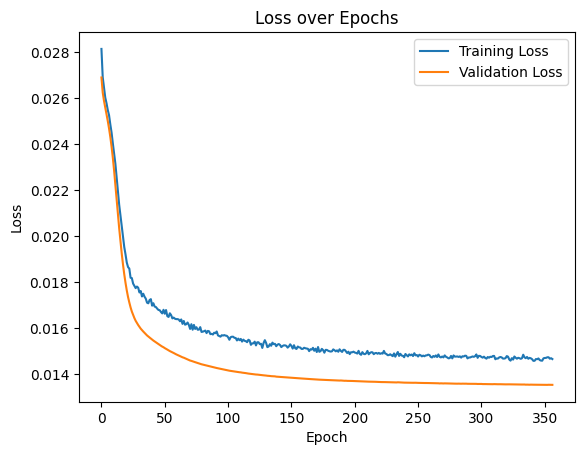

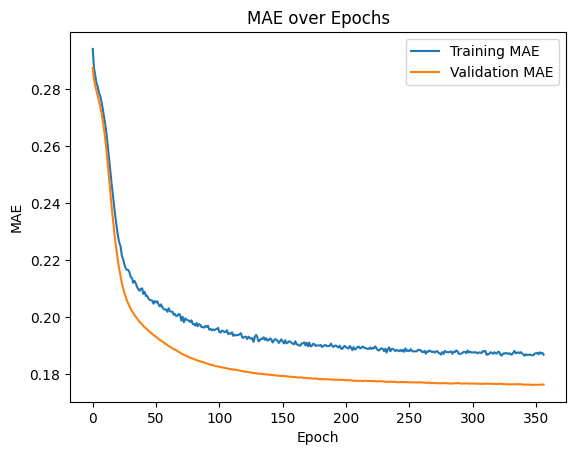

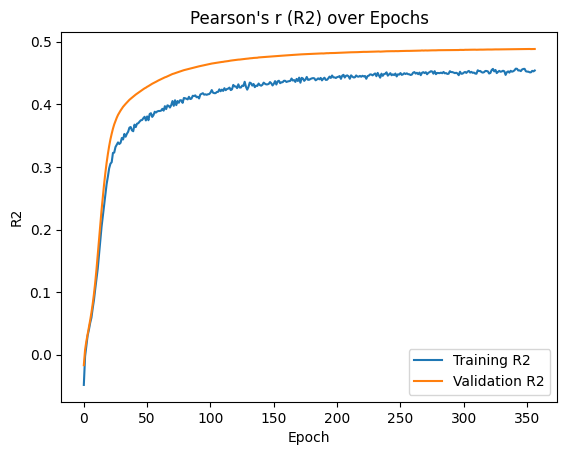

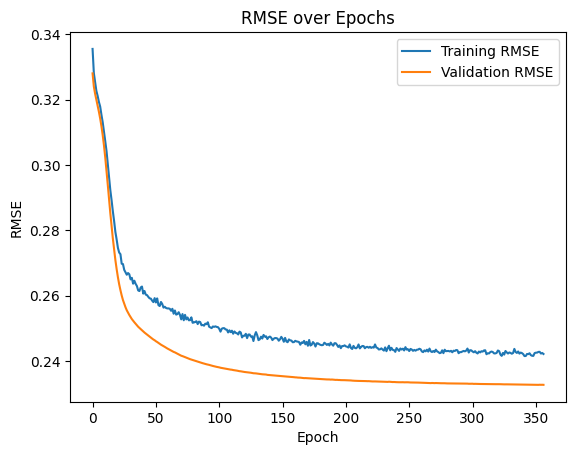

In [10]:
# Plot training and validation loss
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.plot(history['train_mae'], label='Training MAE')
plt.plot(history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()
plt.show()

# Plot training and validation R2
plt.plot(history['train_pearson'], label='Training R2')
plt.plot(history['val_pearson'], label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.title("Pearson's r (R2) over Epochs")
plt.legend()
plt.show()

# Plot training and validation RMSE
plt.plot(history['train_rmse'], label='Training RMSE')
plt.plot(history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title("RMSE over Epochs")
plt.legend()
plt.show()

In [12]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    # Get predictions for the test set
    y_pred = model(X_test_tensor)
    
    # Compute the test loss (MSE)
    test_loss = criterion(y_pred, y_test_tensor).item()

    # Convert predictions and true values to numpy for metric calculations
    y_pred_np = y_pred.numpy().reshape(-1)
    y_test_np = y_test_tensor.numpy().reshape(-1)

    # Calculate MAE, RMSE, and R2
    test_mae = mean_absolute_error(y_test_np, y_pred_np)
    test_rmse = np.sqrt(mean_absolute_error(y_test_np, y_pred_np))
    test_r2 = r2_score(y_test_np, y_pred_np)

    # Print the error metrics
    print(f'Test Loss (MSE): {test_loss:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test R2 Score: {test_r2:.4f}')

Test Loss (MSE): 0.0582
Test MAE: 0.1843
Test RMSE: 0.4293
Test R2 Score: 0.4421
